[View in Colaboratory](https://colab.research.google.com/github/kmanicka/CarND-Behavioral-Cloning-P3/blob/master/Model.ipynb)

# Udacity Car ND : Behavioral Cloning Project

This notebook is used to build and train the model used for driving the car autonomously 


## Versions 


#### Versions 7
- Try doing bulk read of images during Data Generator
- Exclude the left and right images
- Implement Validation Generator  (weights-7.hdf5)
- Shuffle is already being done by fit_generator, so remove functionality (weights-7A.hdf5)
- Trying the fit_generator parallel exectution to speed things up. (weights-7B.hdf5)

Results : 
- Bulk read of images significantly improved the speed of training.
- Doing shuffel on on_epoch_end improved training results. Note fit_geneator also shuffles at batch level.
- Using Parallel Execution reduced the training time per epoc to 10s without any impact on the model / training. 


#### Versions 6
- Use Data Generator
- Data Augumentation : Left, Right and horizontally reveresed images. 
Result: Due to Data Generated logic training has become significantly slower. 
Did not see much improvement by Data Augumentation. 
instead the movement of car has be


#### Versions 5
- Merged build and train cells. 
- Merged Load and prepare data

#### Versions 4
- Normalization and croping in the Keras Layer
- Dropout in 3 layers 0.25
- Files changed the model and the drive.py 
Results : 
- Had a good run in the simulator. 

#### Versions 3
- Reduced the image height to concentrate on roads only.  
- the training and prediction image has changed. 

Result: The car drived well till it got distracted at road with brown road curb.  

#### Versions 2
A basic Lenet Model updated for linear regression. 


##  Workspace setup

* clean the workspace 
* download and unzip files
* list and assert files

```
date > log.txt
rm -rf *.zip  >> log.txt 2>&1
wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip >> log.txt 2>&1
unzip data.zip >> log.txt 2>&1
date >> log.txt 2>&1

ls
ls data
ls data/IMG | wc
```

### Data Generator 

In [103]:
# Reference https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html 

from skimage.io import imread
from  keras.utils import  Sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



class TrainBehavioralDataGenerator(Sequence):
    
    def __init__(self,base_dir, batch_size, train_val_split=0.2) :
        
        self.base_dir = base_dir
        self.batch_size = batch_size

        driving_log = pd.read_csv(self.base_dir + 'driving_log.csv', sep=',')
        self.data = driving_log[["center","steering"]]

        data_size = len(self.data)
        train_size = int((1-train_val_split) * data_size)

        indexes = np.arange(data_size)
        np.random.shuffle(indexes)

        self.indexes = indexes[:train_size]
        self.validation_indexes = indexes[train_size:] 
            
    
    def __len__(self):
        return int(np.ceil(len(self.indexes) / float(self.batch_size)))

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        file_names = self.data.iloc[indexes,0]
        X = np.array([np.array(imread(self.base_dir + fname)) for fname in file_names])
        #y= np.reshape(self.data.iloc[indexes,1] , (len(indexes),1))
        y= self.data.iloc[indexes,1]
        return X, y

    
class ValidationBehavioralDataGenerator(TrainBehavioralDataGenerator):
    
    def __init__(self,train_generator) :        
        self.base_dir = train_generator.base_dir
        self.batch_size = train_generator.batch_size
        self.data = train_generator.data
        
        ## Key item use the validation set from Train Data Generator as Indexes here. 
        self.indexes = train_generator.validation_indexes


    

(8036, 2)
(6428,)
(1608,)
(8036, 2)
(1608,)
(10, 160, 320, 3)
(10, 1)
[ 0.1957194]
[ 0.1957194]
[ 0.1957194]


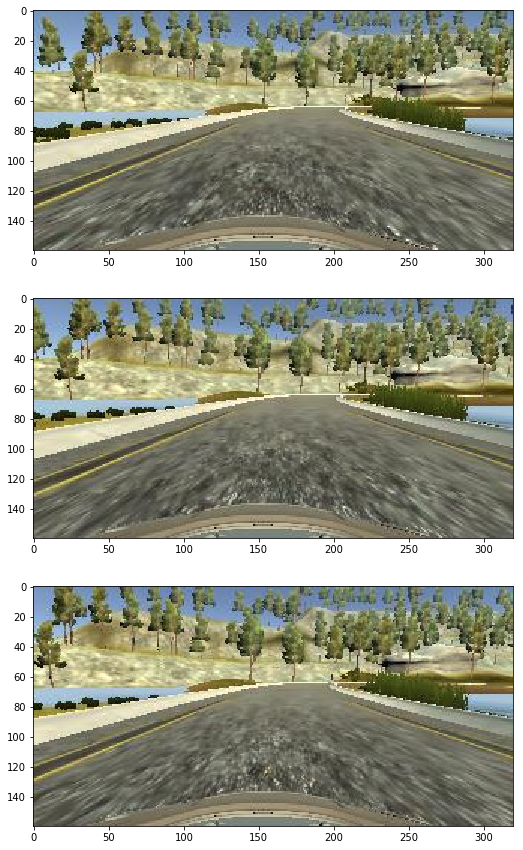

In [105]:
# Tests for the BehavioralDataGenerator 


train_generator = TrainBehavioralDataGenerator('data/',10)
print(train_generator.data.shape)
print(train_generator.indexes.shape)
print(train_generator.validation_indexes.shape)
validation_generator = ValidationBehavioralDataGenerator(train_generator)
print(validation_generator.data.shape)
print(validation_generator.indexes.shape)


fig=plt.figure(figsize=(15, 15))
rows,columns = 3,1
i=0

#center image
row = 270
X_batch, y_batch =generator.__getitem__(row)

print(X_batch.shape)
print(y_batch.shape)

print(y_batch[0])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[0])

print(y_batch[1])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[1])

print(y_batch[2])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[2])

#Expedted : 0.1765823


# Build and Train Model



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_19 (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_19 (Cropping2D)   (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 86, 316, 4)        304       
_________________________________________________________________
activation_91 (Activation)   (None, 86, 316, 4)        0         
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 43, 158, 4)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 39, 154, 8)        808       
_________________________________________________________________
activation_92 (Activation)   (None, 39, 154, 8)        0         
__________

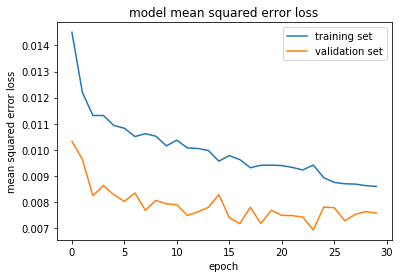

In [108]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Cropping2D,Lambda 
from keras.callbacks import ModelCheckpoint

def get_model(input_shape) :

    model = Sequential()
    
    #Layer Normilization
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
    
    #Layer Cropping
    model.add(Cropping2D(cropping=((50,20), (0,0))))

    #Layer Conv 1 
    model.add(Conv2D(4, (5, 5), padding="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #Layer Conv 2
    model.add(Conv2D(8, (5, 5), padding="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))


    #Layer Conv 3
    model.add(Conv2D(16, (5, 5), padding="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    #Layer Dense 1
    model.add(Dense(32))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))

    #Layer Dense 2
    model.add(Dense(8))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))

    #Layer Dense 4
    model.add(Dense(1)) 

    model.compile(loss='mse', optimizer='adam')


    return model

batch_size = 32
height = 160
width = 320
channels = 3

model = get_model((height,width,channels))
model.summary()

#weights_filepath="weights-7-{epoch:02d}.hdf5"

weights_filepath="weights-7C.hdf5"

checkpoint = ModelCheckpoint(weights_filepath, verbose=1)


training_generator = TrainBehavioralDataGenerator('data/',batch_size)
validation_generator = ValidationBehavioralDataGenerator(training_generator)

history_object = model.fit_generator(generator=training_generator,
                                     validation_data=validation_generator,
                                     epochs=30, 
                                     verbose=1,
                                     use_multiprocessing=True,
                                     workers=10,
                                     callbacks=[checkpoint])

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

